## Libarary Used

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
import shutil
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image

In [ ]:
import tensorflow as tf
import tensorflowjs as tfjs
from keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import MobileNetV2

In [12]:
import PIL
import matplotlib
import sklearn

requirements = [
    f"tensorflow=={tf.__version__}",
    f"numpy=={np.__version__}",
    f"Pillow=={PIL.__version__}",
    f"matplotlib=={matplotlib.__version__}",
    f"tensorflowjs=={tfjs.__version__}",
    f"pandas=={pd.__version__}",
    f"seaborn=={sns.__version__}",
    f"scikit-learn=={sklearn.__version__}",
]

with open("requirements.txt", "w") as f:
    f.write("\n".join(requirements))

print("requirements.txt berhasil dibuat.")

requirements.txt berhasil dibuat.


## Data Preparation

In [5]:
data_dir = "/kaggle/input/animals10/raw-img"

In [6]:
translate = {"ragno":"spider" ,"cane": "dog", "cavallo": "horse", "elefante": "elephant", "farfalla": "butterfly", "gallina": "chicken", "gatto": "cat", "mucca": "cow", "pecora": "sheep", "scoiattolo": "squirrel", "dog": "cane", "cavallo": "horse", "elephant" : "elefante", "butterfly": "farfalla", "chicken": "gallina", "cat": "gatto", "cow": "mucca", "spider": "ragno", "squirrel": "scoiattolo"}

In [8]:
filepaths = []
labels = []

for label in os.listdir(data_dir):
    class_path = os.path.join(data_dir, label)
    if os.path.isdir(class_path):
        for file in os.listdir(class_path):
            filepaths.append(os.path.join(class_path, file))
            labels.append(translate[label])

df = pd.DataFrame({
    "filepath": filepaths,
    "label": labels
})

df

,filepath,label
0,/kaggle/input/animals10/raw-img/cavallo/OIP-md...,horse
1,/kaggle/input/animals10/raw-img/cavallo/OIP-TP...,horse
2,/kaggle/input/animals10/raw-img/cavallo/OIP-jl...,horse
3,/kaggle/input/animals10/raw-img/cavallo/OIP-F4...,horse
4,/kaggle/input/animals10/raw-img/cavallo/OIP-UF...,horse
...,...,...
26174,/kaggle/input/animals10/raw-img/farfalla/OIP-4...,butterfly
26175,/kaggle/input/animals10/raw-img/farfalla/OIP-Q...,butterfly
26176,/kaggle/input/animals10/raw-img/farfalla/OIP-1...,butterfly
26177,/kaggle/input/animals10/raw-img/farfalla/eb32b...,butterfly


### Data Loading

In [12]:
 def print_images_resolution(directory):
    unique_sizes = set()
    total_images = 0
 
    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)
        image_files = os.listdir(subdir_path)
        num_images = len(image_files)
        print(f"{translate[subdir]}: {num_images}")
        total_images += num_images
 
        for img_file in image_files:
            img_path = os.path.join(subdir_path, img_file)
            with Image.open(img_path) as img:
                unique_sizes.add(img.size)

        for size in unique_sizes:
            print(f"- {size}")
        print("---------------")
 
    print(f"\nTotal: {total_images}")
     
print_images_resolution(data_dir)

horse: 2623
- (300, 270)
- (300, 279)
- (300, 126)
- (300, 135)
- (249, 300)
- (238, 300)
- (300, 144)
- (276, 183)
- (300, 229)
- (231, 269)
- (300, 238)
- (200, 300)
- (222, 300)
- (211, 300)
- (300, 247)
- (300, 256)
- (300, 265)
- (279, 300)
- (300, 121)
- (241, 300)
- (230, 300)
- (300, 224)
- (300, 233)
- (300, 242)
- (192, 300)
- (300, 251)
- (203, 300)
- (300, 260)
- (231, 300)
- (250, 250)
- (300, 210)
- (261, 300)
- (300, 219)
- (300, 228)
- (300, 237)
- (300, 246)
- (262, 237)
- (214, 300)
- (291, 300)
- (297, 200)
- (300, 205)
- (300, 214)
- (300, 223)
- (300, 232)
- (300, 241)
- (233, 300)
- (244, 300)
- (200, 141)
- (200, 150)
- (206, 300)
- (195, 300)
- (236, 179)
- (273, 228)
- (300, 191)
- (300, 200)
- (263, 300)
- (274, 300)
- (300, 209)
- (300, 218)
- (300, 227)
- (277, 225)
- (264, 264)
- (225, 300)
- (236, 300)
- (264, 300)
- (240, 190)
- (240, 208)
- (198, 300)
- (300, 186)
- (300, 195)
- (300, 204)
- (255, 300)
- (300, 213)
- (300, 222)
- (149, 300)
- (294, 300)


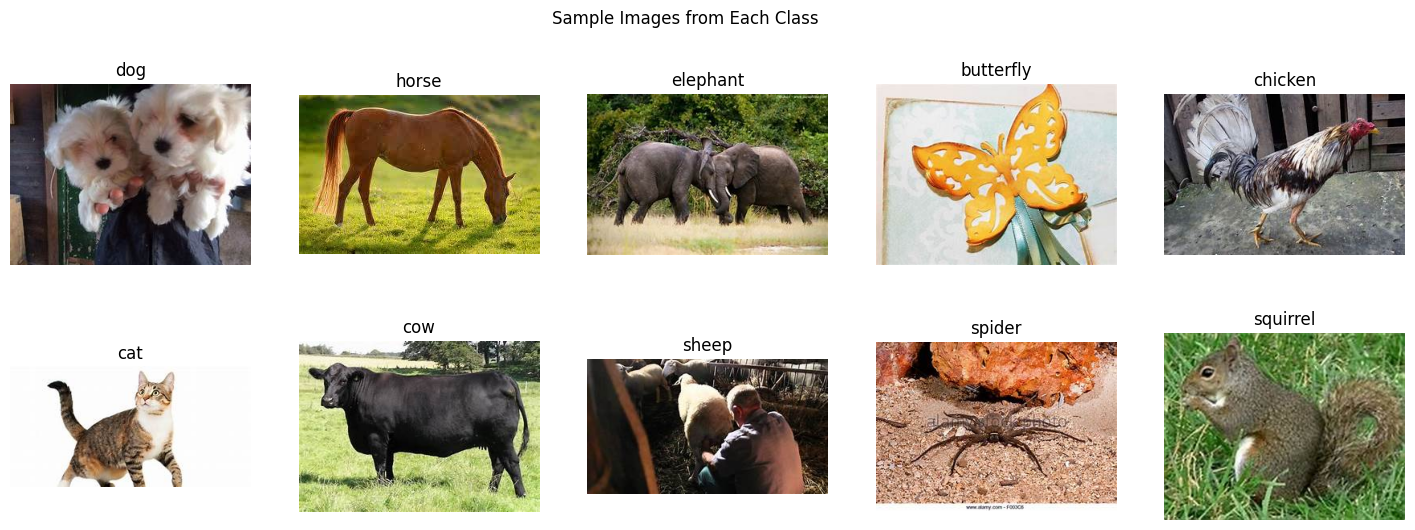

In [13]:
figure, axes = plt.subplots(2, 5, figsize=(18, 6))
figure.suptitle("Sample Images from Each Class", fontsize=12)

images = []
for class_name in sorted(os.listdir(data_dir)):
    class_path = os.path.join(data_dir, class_name)
    if not os.path.isdir(class_path):
        continue
    class_images = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
    if not class_images:
        continue
    images.append(os.path.join(class_path, class_images[np.random.randint(0, len(class_images))])) 

for i, img_path in enumerate(images[:20]):
    img = Image.open(img_path)
    row, col = divmod(i, 5)
    axes[row, col].imshow(img)
    axes[row, col].set_title(
        f"{translate[os.path.basename(os.path.dirname(img_path))]}"
    )
    axes[row, col].axis('off')

### Data Preprocessing

In [16]:
from sklearn.model_selection import train_test_split

# 70% train
train_df, temp_df = train_test_split(
    df,
    test_size=0.30,
    stratify=df["label"],
    random_state=42
)

# 15% val, 15% test
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,
    stratify=temp_df["label"],
    random_state=42
)

print("Train:", len(train_df))
print("Val:", len(val_df))
print("Test:", len(test_df))

Train: 18325
Val: 3927
Test: 3927


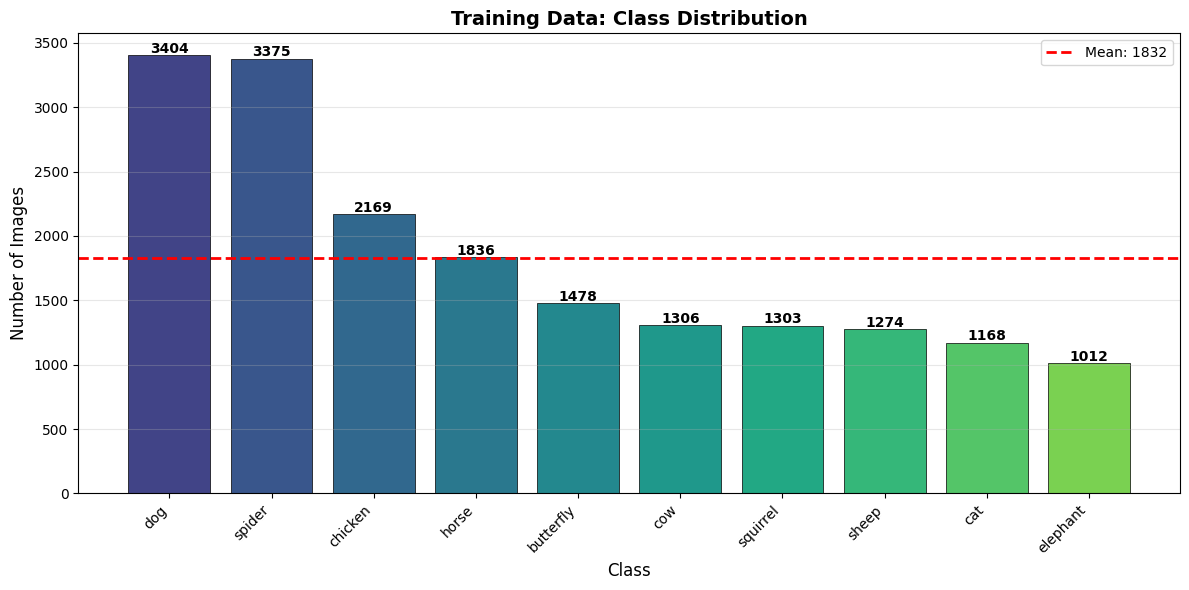


Total training images: 18325
Min: elephant (1012), Max: dog (3404)
Imbalance ratio: 3.36x


In [17]:
counts = train_df["label"].value_counts().values
names = train_df["label"].value_counts().index

# Color gradient
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(names)))

plt.figure(figsize=(12, 6))
bars = plt.bar(names, counts, color=colors, edgecolor='black', linewidth=0.5)

# Add count labels on bars
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 20, 
             str(count), ha='center', fontsize=10, fontweight='bold')

plt.xlabel('Class', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.title('Training Data: Class Distribution', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.axhline(y=np.mean(counts), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(counts):.0f}')
plt.legend()
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nTotal training images: {sum(counts)}")
print(f"Min: {names[-1]} ({counts[-1]}), Max: {names[0]} ({counts[0]})")
print(f"Imbalance ratio: {max(counts)/min(counts):.2f}x")

#### Split Dataset

In [18]:
INPUT_SHAPE = (224,224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col="filepath",
    y_col="label",
    target_size=INPUT_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

val_generator = test_datagen.flow_from_dataframe(
    val_df,
    x_col="filepath",
    y_col="label",
    target_size=INPUT_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col="filepath",
    y_col="label",
    target_size=INPUT_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

Found 18325 validated image filenames belonging to 10 classes.
Found 3927 validated image filenames belonging to 10 classes.
Found 3927 validated image filenames belonging to 10 classes.


## Modelling

In [24]:
# Simpan model terbaik berdasarkan val_accuracy
checkpoint = ModelCheckpoint(
    filepath='/kaggle/working/model-checkpoint/best_model_stage1.keras',   
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
)

# early stopping untuk menghentikan training jika val_loss tidak membaik selama 5 epoch
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',    
    factor=0.2,            
    patience=3,            
    verbose=1,             
    min_lr=1e-7            
)

In [25]:
classes = np.unique(train_generator.classes)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=train_generator.classes
)

class_weights_dict = dict(enumerate(class_weights))
class_weights_dict

{0: np.float64(1.239851150202977),
 1: np.float64(1.5689212328767124),
 2: np.float64(0.8448593822037805),
 3: np.float64(1.4031393568147015),
 4: np.float64(0.538337250293772),
 5: np.float64(1.8107707509881423),
 6: np.float64(0.9980936819172114),
 7: np.float64(1.4383830455259026),
 8: np.float64(0.542962962962963),
 9: np.float64(1.406369915579432)}

In [26]:
base_model = MobileNetV2(weights='imagenet', 
                         include_top=False, 
                         input_shape=(224, 224, 3))
base_model.trainable = True
for layer in base_model.layers[:-20]: 
    layer.trainable = False

model = Sequential([
    base_model,
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 64)       │       737,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 7, 7, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 3, 3, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,106,570 (11.85 MB)

 Trainable params: 2,053,770 (7.83 MB)

 Non-trainable params: 1,052,800 (4.02 MB)

#### Stage 1 - Training

In [27]:
model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    class_weight=class_weights_dict,
    callbacks=[checkpoint, early_stop, reduce_lr]
)

Epoch 1/30
486/573 ━━━━━━━━━━━━━━━━━━━━ 35s 403ms/step - accuracy: 0.7620 - loss: 0.8202

2026-02-22 06:37:55.166049: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-22 06:37:55.302540: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


573/573 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - accuracy: 0.7740 - loss: 0.7815

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2026-02-22 06:38:58.538396: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-22 06:38:58.674643: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


573/573 ━━━━━━━━━━━━━━━━━━━━ 286s 472ms/step - accuracy: 0.7741 - loss: 0.7811 - val_accuracy: 0.8752 - val_loss: 0.4987 - learning_rate: 0.0010
Epoch 2/30
573/573 ━━━━━━━━━━━━━━━━━━━━ 239s 417ms/step - accuracy: 0.9061 - loss: 0.3263 - val_accuracy: 0.9277 - val_loss: 0.2967 - learning_rate: 0.0010
Epoch 3/30
573/573 ━━━━━━━━━━━━━━━━━━━━ 233s 406ms/step - accuracy: 0.9196 - loss: 0.2671 - val_accuracy: 0.9149 - val_loss: 0.3505 - learning_rate: 0.0010
Epoch 4/30
573/573 ━━━━━━━━━━━━━━━━━━━━ 230s 401ms/step - accuracy: 0.9364 - loss: 0.2123 - val_accuracy: 0.9055 - val_loss: 0.4390 - learning_rate: 0.0010
Epoch 5/30
573/573 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.9396 - loss: 0.1923
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
573/573 ━━━━━━━━━━━━━━━━━━━━ 232s 405ms/step - accuracy: 0.9396 - loss: 0.1923 - val_accuracy: 0.9236 - val_loss: 0.3323 - learning_rate: 0.0010
Epoch 6/30
573/573 ━━━━━━━━━━━━━━━━━━━━ 232s 405ms/step - accuracy: 0.9610 - 

## Evaluasi dan Visualisasi

In [31]:
loss, accuracy = model.evaluate(train_generator)
print("Evaluation on data train: ")
print(f"accuracy: {accuracy*100:.2f}")
print(f"loss: {loss}")

573/573 ━━━━━━━━━━━━━━━━━━━━ 233s 407ms/step - accuracy: 0.9972 - loss: 0.0086
Evaluation on data train: 
accuracy: 99.72
loss: 0.009307069703936577


In [32]:
loss, accuracy = model.evaluate(test_generator)
print("Evaluation on data test: ")
print(f"accuracy: {accuracy*100:.2f}")
print(f"loss: {loss}")

123/123 ━━━━━━━━━━━━━━━━━━━━ 12s 98ms/step - accuracy: 0.9605 - loss: 0.1676
Evaluation on data test: 
accuracy: 95.87
loss: 0.18065281212329865


In [36]:
loss, accuracy = model.evaluate(val_generator)
print("Evaluation on data validation: ")
print(f"accuracy: {accuracy*100:.2f}")
print(f"loss: {loss}")

123/123 ━━━━━━━━━━━━━━━━━━━━ 12s 97ms/step - accuracy: 0.9658 - loss: 0.1574
Evaluation on data validation: 
accuracy: 96.33
loss: 0.16204898059368134


123/123 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step
              precision    recall  f1-score   support

   butterfly       0.93      0.98      0.96       317
         cat       0.97      0.93      0.95       250
     chicken       0.98      0.98      0.98       465
         cow       0.89      0.94      0.92       280
         dog       0.97      0.94      0.95       729
    elephant       0.96      0.98      0.97       217
       horse       0.94      0.97      0.96       394
       sheep       0.93      0.92      0.92       273
      spider       0.99      0.97      0.98       723
    squirrel       0.98      0.98      0.98       279

    accuracy                           0.96      3927
   macro avg       0.95      0.96      0.96      3927
weighted avg       0.96      0.96      0.96      3927



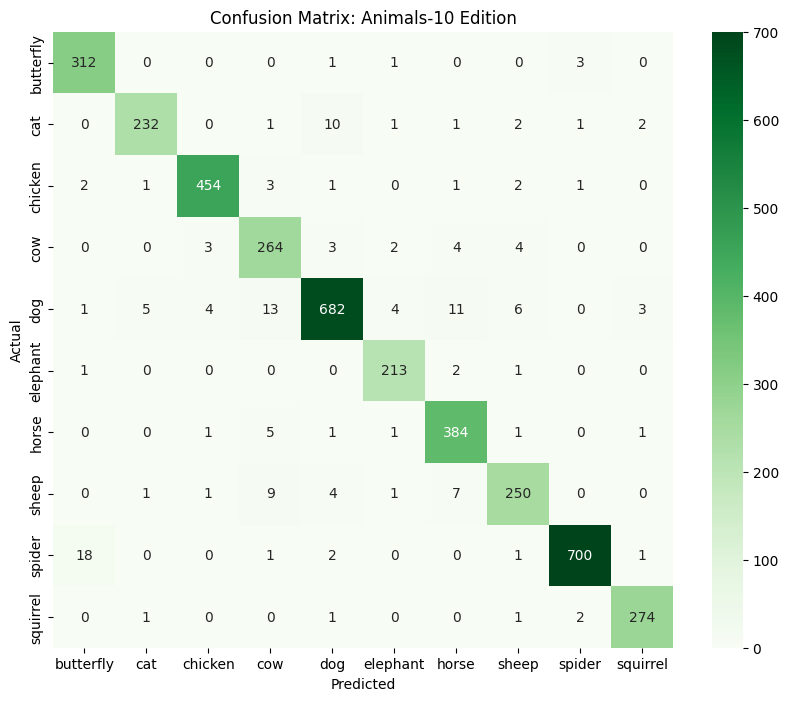

In [39]:
# Prediksi data test
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Ambil label asli
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())

# Print Report
print(classification_report(y_true, y_pred, target_names=class_names))

# Plot Heatmap
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix: Animals-10 Edition')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

#### Visualisasi

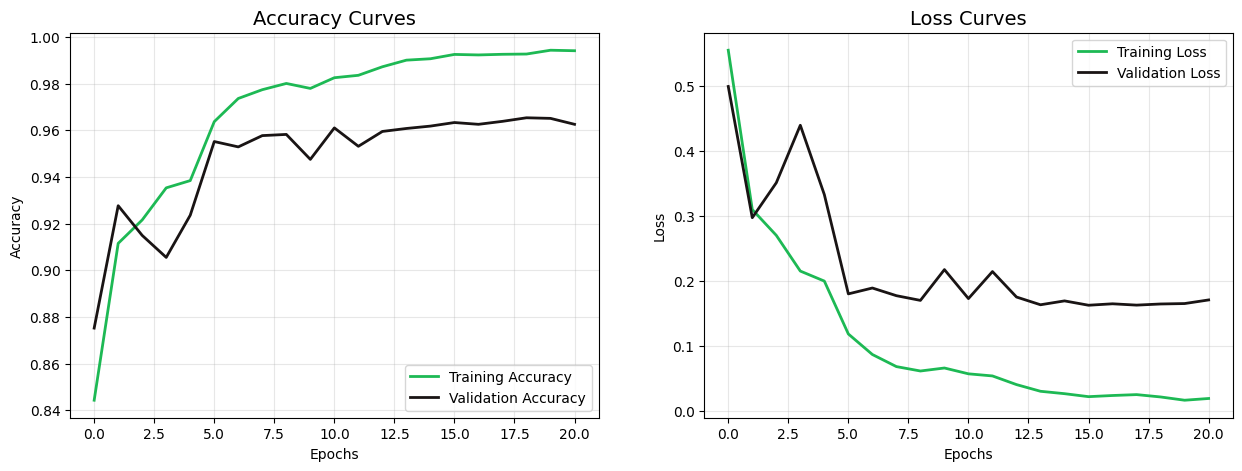

In [40]:
acc = model.history.history['accuracy']
val_acc = model.history.history['val_accuracy']
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(15, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', color='#1DB954', lw=2)
plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='#191414', lw=2)
plt.title('Accuracy Curves', fontsize=14)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', color='#1DB954', lw=2)
plt.plot(epochs_range, val_loss, label='Validation Loss', color='#191414', lw=2)
plt.title('Loss Curves', fontsize=14)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(alpha=0.3)

plt.show()